## **Importações e leitura**

In [ ]:
# Importações

import numpy as np
import pandas as pd

import json

import nltk
from nltk.corpus import stopwords

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Leitura dos dados

df_dataset = pd.read_csv('20052021.csv')

display(df_dataset.shape)
display(df_dataset.head())

(738, 7)

,_id,created_at,tweet_content,keyword,user_location,entities,classification
0,ObjectId(6091f3547ef2d107a44055cc),2021-05-04 12:30:48,mds nubank nunca libera mais limite pra mim,['Nubank'],Goiânia,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
1,ObjectId(6091f3547ef2d107a44055cd),2021-05-04 12:31:09,mais viciado que a bateria do meu celular só e...,['Coca-cola'],Balneário Camboriú,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
2,ObjectId(6091f3547ef2d107a44055ce),2021-05-04 12:31:27,toda vez que vejo Nubank nos tt vou lá conferi...,['Nubank'],None,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
3,ObjectId(6091f3547ef2d107a44055cf),2021-05-04 12:31:25,Pedi 10k de limite pra Nubank serasi?,['Nubank'],"Rio de Janeiro, Brasil","{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":true,""created_at"":""2021-05-..."
4,ObjectId(6091f3547ef2d107a44055d0),2021-05-04 12:31:20,@kayofeer @nubank Aconteceu isso c a minha mãe...,['Nubank'],"Macaé, Brasil","{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."


## **Engenharia de atributos**

In [ ]:
# Verificação de valores nulos

display(df_dataset.isna().sum())
# display(df_dataset[df_dataset.isnull().any(axis=1)])

_id                0
created_at         0
tweet_content      0
keyword            0
user_location      1
entities           0
classification    72
dtype: int64

**Como existem 72 ocasiões cujos campos de classificação estão vazios, será feita a remoção desses registros**

In [ ]:
# Remoção de atributos irrelevantes para a análise

df_removed = df_dataset.drop(['_id', 'created_at', 'user_location', 'entities'], axis=1)

display(df_removed.shape)
display(df_removed.head(n=2))

(738, 3)

,tweet_content,keyword,classification
0,mds nubank nunca libera mais limite pra mim,['Nubank'],"[{""classification"":false,""created_at"":""2021-05..."
1,mais viciado que a bateria do meu celular só e...,['Coca-cola'],"[{""classification"":false,""created_at"":""2021-05..."


In [ ]:
# Remoção de amostras onde o campo de classifificação é vazio

df_dropna = df_removed.dropna(subset = ['classification'])

display(df_removed.shape)
display(df_dropna.shape)

(738, 3)

(666, 3)

### **Análise de keywords**

Counter({"['Boticário']": 8,
         "['Coca cola']": 64,
         "['Coca-cola']": 16,
         "['Nike', 'SHEIN']": 1,
         "['Nike', 'Xiaomi']": 1,
         "['Nike']": 201,
         "['Nubank']": 236,
         "['SHEIN']": 169,
         "['Xiaomi']": 26,
         '[]': 16})

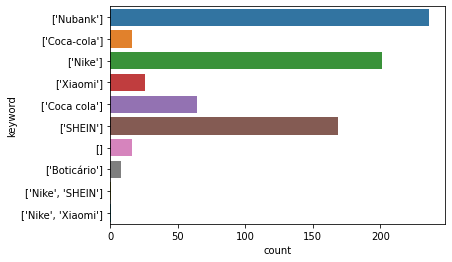

In [ ]:
# Valores

display(Counter(df_dataset["keyword"]))


# Histograma

sns.countplot(y="keyword", data=df_dataset)

In [ ]:
# Outro modo para gerar o mesmo gráfico

# plt.hist(df_dataset["keyword"].values, bins=20, color='red', edgecolor='black', linewidth=0.9)
# plt.xticks(rotation=90)
# plt.show()

**Como existem 2 grafias distintas para "Coca-cola", será feita uma normalização desses valores**

In [ ]:
# Normalização de "Coca-Cola"

search = "Coca cola"
replacement = "Coca-cola"

df_normalized = df_dropna.copy()
df_normalized["keyword"] = df_dropna["keyword"].apply(
    lambda keywords: keywords.lower().replace(search.lower(), replacement) if search.lower() in keywords.lower() else keywords)

display(Counter(df_normalized["keyword"]))

Counter({"['Boticário']": 7,
         "['Coca-cola']": 71,
         "['Nike', 'SHEIN']": 1,
         "['Nike', 'Xiaomi']": 1,
         "['Nike']": 177,
         "['Nubank']": 221,
         "['SHEIN']": 150,
         "['Xiaomi']": 23,
         '[]': 15})

#### Testes de Counter

In [ ]:
# c = Counter([True, False, False, True, True]).most_common()[0][0]
# print(c)

In [ ]:
# from collections import Counter

# def reducer(item):
#   return item['classification']

# result = list(map(reducer, [
#   {'classification': True, 'created_at': 0 },
#   {'classification': False, 'created_at': 0 },
#   {'classification': True, 'created_at': 0 },
# ]))

# result_counter = Counter(result).most_common()[0][0]
# print(result_counter)

In [ ]:
# test_list = [
#   {'classification': True, 'created_at': 0 },
#   {'classification': False, 'created_at': 0 },
#   {'classification': True, 'created_at': 0 },
# ]

# def get_classification(myList):
#   print('input_list', myList, type(myList))
#   return Counter(list(map(lambda item: item['classification'], myList))).most_common()[0][0]

# print(get_classification(test_list))

In [ ]:
# import json

# data = json.loads('[{"classification": true, "created_at": 0 },{"classification": false, "created_at": 0 },{"classification": true, "created_at": 0 }]')
# print(type(data), data)

## **Tratamento da classificação**

Como são 3 classificações para cada registro, ganha a classificação da **maioria** dos registros

Exemplos:

- True, True, False => True
- False, True, False => False

In [ ]:
# Criação de um campo de resultado de classificação com a maior ocorrência entre as classificaçações

pd.options.mode.chained_assignment = None

def reducer(input_dict):
  return input_dict['classification']

def get_classification(input_list):
  return Counter(list(map(reducer, json.loads(input_list)))).most_common()[0][0]

# df_classified = df_normalized.apply(lambda item: get_classification(item[2]), axis=1)

df_normalized['classified'] = df_normalized['classification'].map(lambda classification_list: get_classification(classification_list))

df_classified = df_normalized.drop(['classification'], axis=1)

In [ ]:
# Transformação numérica da classificação

df_classified['classified'][df_classified['classified'] == True] = 1
df_classified['classified'][df_classified['classified'] == False] = 0

display(df_classified.head())

,tweet_content,keyword,classified
0,mds nubank nunca libera mais limite pra mim,['Nubank'],0.0
1,mais viciado que a bateria do meu celular só e...,['Coca-cola'],1.0
2,toda vez que vejo Nubank nos tt vou lá conferi...,['Nubank'],0.0
3,Pedi 10k de limite pra Nubank serasi?,['Nubank'],1.0
4,@kayofeer @nubank Aconteceu isso c a minha mãe...,['Nubank'],1.0


## **Pré-processamento**

1. Tokenização
2. Remoção de stopwords

### 1. Tokenização

In [ ]:
# # Tokenização

# import nltk
# nltk.download('punkt', quiet=True)

# df_tokens = pd.DataFrame(df_classified['tweet_content'].apply(lambda column: nltk.word_tokenize(column)))
# # df_tokens = pd.DataFrame(df_classified.apply(lambda item: 'a' if item.name == 'classified' else item))

# display(df_tokens.head())

### 2. Remoção de stopwords

In [ ]:
# Remoção de stopwords

nltk.download('stopwords', quiet=True)

stop = stopwords.words('portuguese')

df_removed_stopwords = df_classified.copy()
df_removed_stopwords['tweet_content'] = df_classified['tweet_content'].apply(lambda tweet: [word for word in tweet.split() if word not in stop])

display(df_removed_stopwords.head())

,tweet_content,keyword,classified
0,"[mds, nubank, nunca, libera, limite, pra, mim]",['Nubank'],0.0
1,"[viciado, bateria, celular, coca-cola, 🤦🏻‍♀️🤦🏻...",['Coca-cola'],1.0
2,"[toda, vez, vejo, Nubank, tt, vou, lá, conferi...",['Nubank'],0.0
3,"[Pedi, 10k, limite, pra, Nubank, serasi?]",['Nubank'],1.0
4,"[@kayofeer, @nubank, Aconteceu, c, mãe,, quase...",['Nubank'],1.0


## **Análise de classificações**

### Geral

Counter({0.0: 306, 1.0: 360})

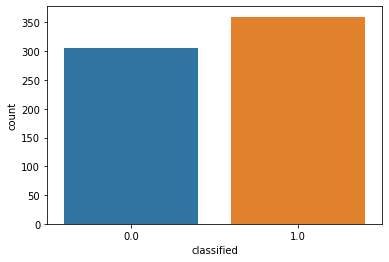

In [ ]:
# Valores

display(Counter(df_removed_stopwords['classified']))


# Histograma


sns.countplot(x="classified", data=df_removed_stopwords)

### Por keywords

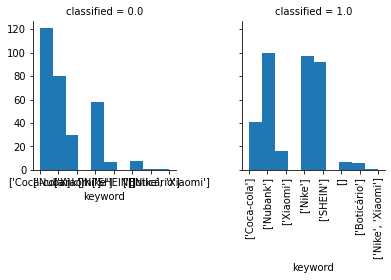

In [ ]:
sns.FacetGrid(df_removed_stopwords, col='classified').map(plt.hist, 'keyword', bins=10)
plt.xticks(rotation=90)
plt.show()